### Importing libraries

In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [4]:
from sklearn.metrics import mean_squared_error

In [5]:
import mlflow

In [6]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("new-experiment")

2024/05/27 09:20:04 INFO mlflow.tracking.fluent: Experiment with name 'new-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/Study/Conda Projects/mlops-zoom/02-exp-tracking/mlruns/1', creation_time=1716826804742, experiment_id='1', last_update_time=1716826804742, lifecycle_stage='active', name='new-experiment', tags={}>

### Reading the dataset

In [7]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    # Creating the target variable: duration
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

    # Converting duration into minutes
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds()/60)

    df = df[((df['duration'] >= 1) & (df['duration'] <= 60))]

    categorical = ['PULocationID','DOLocationID']
    numerical = ['trip_distance']

    df[categorical] = df[categorical].astype(str)
    df['PU_DO'] = df['PULocationID']+"_"+df['DOLocationID']

    return df

In [9]:
df_train = read_dataframe("D:\Study\Conda Projects\mlops-zoom\data\green\green_tripdata_2023-01.parquet")

In [10]:
df_val = read_dataframe("D:\Study\Conda Projects\mlops-zoom\data\green\green_tripdata_2023-02.parquet")

In [11]:
len(df_train),len(df_val)

(65946, 62574)

### Exploring the dataset

In [12]:
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,...,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75,11.016667,166_143
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,...,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00,6.766667,24_43
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,...,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00,6.333333,223_179
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,...,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00,5.816667,41_238
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,...,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00,5.966667,41_74


In [13]:
df_train.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
PU_DO                            object
dtype: object

In [14]:
df_train['duration'].head()

0    11.016667
1     6.766667
2     6.333333
3     5.816667
4     5.966667
Name: duration, dtype: float64

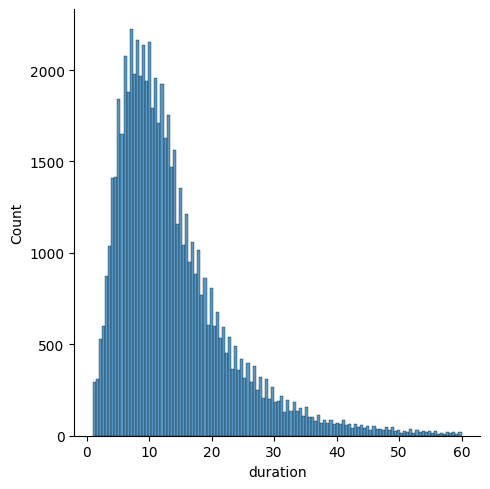

In [15]:
sns.displot(df_train['duration'])

In [16]:
df_train['duration'].describe(percentiles=[0.95,0.98,0.99])

count    65946.000000
mean        13.747575
std          9.023810
min          1.000000
50%         11.533333
95%         31.816667
98%         40.501667
99%         46.592500
max         60.000000
Name: duration, dtype: float64

### Training and Validation Set

In [17]:
categorical = ['PU_DO']
numerical = ['trip_distance']

In [18]:
df_train.shape, df_val.shape

((65946, 22), (62574, 22))

In [19]:
dv = DictVectorizer()
train_dicts = df_train[categorical+numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [20]:
target='duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [21]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_true=y_val,y_pred=y_pred, squared=False)

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6.037710512990993

In [25]:
with mlflow.start_run():
    mlflow.set_tag("developer","Anish")

    mlflow.log_param("train-data-path","D:\Study\Conda Projects\mlops-zoom\data\green\green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path","D:\Study\Conda Projects\mlops-zoom\data\green\green_tripdata_2023-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha",alpha)
    # Lasso Regression
    lasso = Lasso()
    lasso.fit(X_train,y_train)
    y_pred = lasso.predict(X_val)
    rmse = mean_squared_error(y_true=y_val,y_pred=y_pred, squared=False)

    mlflow.log_metric("rmse",rmse)

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
sns.histplot(data=y_pred,kde=True,label='Prediction')
sns.histplot(data=y_train,kde=True,label='actual')
plt.legend()
plt.show()

### Saving the Model

In [22]:
import pickle

In [23]:
with open('D:\Study\Conda Projects\mlops-zoom\\02-exp-tracking\models\lr_model.bin','wb') as f_out:
    pickle.dump((dv,lr),f_out)

### MLFLow Sample Run

In [28]:
import xgboost as xgb

In [29]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [30]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [31]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [32]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [33]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:39:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.79858                           
[1]	validation-rmse:8.33727                           
[2]	validation-rmse:7.92959                           
[3]	validation-rmse:7.57533                           
[4]	validation-rmse:7.25847                           
[5]	validation-rmse:6.98612                           
[6]	validation-rmse:6.74779                           
[7]	validation-rmse:6.54419                           
[8]	validation-rmse:6.36872                           
[9]	validation-rmse:6.21490                           
[10]	validation-rmse:6.08388                          
[11]	validation-rmse:5.96503                          
[12]	validation-rmse:5.86865                          
[13]	validation-rmse:5.78706                          
[14]	validation-rmse:5.71354                          
[15]	validation-rmse:5.65538                          
[16]	validation-rmse:5.60101                          
[17]	validation-rmse:5.55152                          
[18]	valid

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:7.96212                                                    
[1]	validation-rmse:7.05054                                                    
[2]	validation-rmse:6.45243                                                    
[3]	validation-rmse:6.07388                                                    
  2%|▏         | 1/50 [00:30<24:37, 30.16s/trial, best loss: 5.230733347192576]

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:39:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:5.83536                                                    
[5]	validation-rmse:5.68490                                                    
[6]	validation-rmse:5.59087                                                    
[7]	validation-rmse:5.52795                                                    
[8]	validation-rmse:5.48662                                                    
[9]	validation-rmse:5.46029                                                    
[10]	validation-rmse:5.44085                                                   
[11]	validation-rmse:5.42531                                                   
[12]	validation-rmse:5.41246                                                   
[13]	validation-rmse:5.40577                                                   
[14]	validation-rmse:5.39535                                                   
[15]	validation-rmse:5.38690                                                   
[16]	validation-rmse:5.38437            

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.95325                                                    
[1]	validation-rmse:7.00476                                                    
[2]	validation-rmse:6.36138                                                    
[3]	validation-rmse:5.94133                                                    
[4]	validation-rmse:5.67156                                                    
[5]	validation-rmse:5.49657                                                    
[6]	validation-rmse:5.38969                                                    
[7]	validation-rmse:5.31750                                                    
[8]	validation-rmse:5.26837                                                    
[9]	validation-rmse:5.23711                                                    
[10]	validation-rmse:5.21862                                                   
[11]	validation-rmse:5.20100                                                   
[12]	validation-rmse:5.19032            

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:40:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.90597                                                    
[1]	validation-rmse:6.93647                                                    
[2]	validation-rmse:6.29386                                                    
[3]	validation-rmse:5.88244                                                    
[4]	validation-rmse:5.61678                                                    
[5]	validation-rmse:5.45296                                                    
[6]	validation-rmse:5.35505                                                    
[7]	validation-rmse:5.29185                                                    
[8]	validation-rmse:5.25317                                                    
[9]	validation-rmse:5.22648                                                    
[10]	validation-rmse:5.21082                                                   
[11]	validation-rmse:5.19863                                                   
[12]	validation-rmse:5.18958            

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  8%|▊         | 4/50 [01:33<18:25, 24.03s/trial, best loss: 5.161867578182715]

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:41:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.62006                                                    
[1]	validation-rmse:8.02846                                                    
[2]	validation-rmse:7.53335                                                    
[3]	validation-rmse:7.12113                                                    
[4]	validation-rmse:6.78015                                                    
[5]	validation-rmse:6.49990                                                    
[6]	validation-rmse:6.27127                                                    
[7]	validation-rmse:6.08471                                                    
[8]	validation-rmse:5.93415                                                    
[9]	validation-rmse:5.81199                                                    
[10]	validation-rmse:5.71313                                                   
[11]	validation-rmse:5.63294                                                   
[12]	validation-rmse:5.56861            

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.74169                                                    
[1]	validation-rmse:8.23620                                                    
[2]	validation-rmse:7.79497                                                    
[3]	validation-rmse:7.41583                                                    
[4]	validation-rmse:7.08593                                                    
[5]	validation-rmse:6.80677                                                    
[6]	validation-rmse:6.56521                                                    
[7]	validation-rmse:6.35872                                                    
[8]	validation-rmse:6.18464                                                    
[9]	validation-rmse:6.03424                                                    
[10]	validation-rmse:5.90899                                                   
[11]	validation-rmse:5.80302                                                   
[12]	validation-rmse:5.71592            

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:41:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.18776                                                    
[1]	validation-rmse:6.12690                                                    
[2]	validation-rmse:5.63917                                                    
[3]	validation-rmse:5.41736                                                    
[4]	validation-rmse:5.31579                                                    
[5]	validation-rmse:5.26169                                                    
[6]	validation-rmse:5.23774                                                    
[7]	validation-rmse:5.21853                                                    
[8]	validation-rmse:5.20411                                                    
[9]	validation-rmse:5.19789                                                    
[10]	validation-rmse:5.19489                                                   
[11]	validation-rmse:5.19029                                                   
[12]	validation-rmse:5.18808            

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.48496                                                    
[1]	validation-rmse:7.80353                                                    
[2]	validation-rmse:7.25509                                                    
[3]	validation-rmse:6.81783                                                    
[4]	validation-rmse:6.47298                                                    
[5]	validation-rmse:6.20310                                                    
[6]	validation-rmse:5.99320                                                    
[7]	validation-rmse:5.83088                                                    
[8]	validation-rmse:5.70559                                                    
[9]	validation-rmse:5.60985                                                    
[10]	validation-rmse:5.53484                                                   
[11]	validation-rmse:5.47613                                                   
[12]	validation-rmse:5.43079            

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.56967                                                    
[1]	validation-rmse:7.94838                                                    
 16%|█▌        | 8/50 [03:08<17:29, 24.99s/trial, best loss: 5.133641945374218]

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.44123                                                    
[3]	validation-rmse:7.02736                                                    
[4]	validation-rmse:6.69536                                                    
[5]	validation-rmse:6.42803                                                    
[6]	validation-rmse:6.21357                                                    
[7]	validation-rmse:6.04589                                                    
[8]	validation-rmse:5.91191                                                    
[9]	validation-rmse:5.80565                                                    
[10]	validation-rmse:5.72172                                                   
[11]	validation-rmse:5.65121                                                   
[12]	validation-rmse:5.59634                                                   
[13]	validation-rmse:5.55231                                                   
[14]	validation-rmse:5.51655            

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.71319                                                    
[1]	validation-rmse:6.71500                                                    
[2]	validation-rmse:6.11610                                                    
[3]	validation-rmse:5.76023                                                    
[4]	validation-rmse:5.57985                                                    
[5]	validation-rmse:5.44656                                                    
[6]	validation-rmse:5.39033                                                    
[7]	validation-rmse:5.35521                                                    
[8]	validation-rmse:5.32267                                                    
[9]	validation-rmse:5.31423                                                    
[10]	validation-rmse:5.30487                                                   
[11]	validation-rmse:5.30095                                                   
[12]	validation-rmse:5.29736            

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:43:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.78177                                                     
[1]	validation-rmse:5.82416                                                     
[2]	validation-rmse:5.47500                                                     
[3]	validation-rmse:5.35497                                                     
[4]	validation-rmse:5.30627                                                     
[5]	validation-rmse:5.28241                                                     
[6]	validation-rmse:5.26854                                                     
[7]	validation-rmse:5.26121                                                     
[8]	validation-rmse:5.25598                                                     
[9]	validation-rmse:5.25526                                                     
[10]	validation-rmse:5.25210                                                    
[11]	validation-rmse:5.24639                                                    
[12]	validation-rmse:5.24410

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:43:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.58809                                                     
[1]	validation-rmse:5.64316                                                     
[2]	validation-rmse:5.34585                                                     
[3]	validation-rmse:5.24074                                                     
[4]	validation-rmse:5.19955                                                     
[5]	validation-rmse:5.18241                                                     
[6]	validation-rmse:5.17399                                                     
[7]	validation-rmse:5.16989                                                     
[8]	validation-rmse:5.17070                                                     
[9]	validation-rmse:5.16809                                                     
[10]	validation-rmse:5.16522                                                    
[11]	validation-rmse:5.16506                                                    
[12]	validation-rmse:5.16368

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:43:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.00590                                                     
[1]	validation-rmse:8.71277                                                     
[2]	validation-rmse:8.44055                                                     
[3]	validation-rmse:8.18869                                                     
[4]	validation-rmse:7.95505                                                     
[5]	validation-rmse:7.73946                                                     
[6]	validation-rmse:7.54099                                                     
[7]	validation-rmse:7.35655                                                     
[8]	validation-rmse:7.18763                                                     
[9]	validation-rmse:7.03311                                                     
[10]	validation-rmse:6.89037                                                    
[11]	validation-rmse:6.75958                                                    
[12]	validation-rmse:6.63708

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:43:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.62256                                                     
[1]	validation-rmse:6.58369                                                     
[2]	validation-rmse:5.98657                                                     
[3]	validation-rmse:5.64782                                                     
[4]	validation-rmse:5.46490                                                     
[5]	validation-rmse:5.35438                                                     
[6]	validation-rmse:5.29385                                                     
[7]	validation-rmse:5.25548                                                     
[8]	validation-rmse:5.22897                                                     
[9]	validation-rmse:5.21334                                                     
[10]	validation-rmse:5.20683                                                    
[11]	validation-rmse:5.19431                                                    
[12]	validation-rmse:5.19002

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.12241                                                     
[1]	validation-rmse:7.27066                                                     
[2]	validation-rmse:6.67282                                                     
[3]	validation-rmse:6.26588                                                     
[4]	validation-rmse:5.99531                                                     
[5]	validation-rmse:5.81231                                                     
 28%|██▊       | 14/50 [04:34<09:24, 15.67s/trial, best loss: 5.118845038713622]

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:44:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:5.69185                                                     
[7]	validation-rmse:5.61120                                                     
[8]	validation-rmse:5.55764                                                     
[9]	validation-rmse:5.51513                                                     
[10]	validation-rmse:5.48779                                                    
[11]	validation-rmse:5.46952                                                    
[12]	validation-rmse:5.45443                                                    
[13]	validation-rmse:5.44279                                                    
[14]	validation-rmse:5.43547                                                    
[15]	validation-rmse:5.42891                                                    
[16]	validation-rmse:5.42426                                                    
[17]	validation-rmse:5.42040                                                    
[18]	validation-rmse:5.41777

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:44:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.48266                                                     
[1]	validation-rmse:7.79631                                                     
[2]	validation-rmse:7.23862                                                     
[3]	validation-rmse:6.78915                                                     
[4]	validation-rmse:6.43526                                                     
[5]	validation-rmse:6.15373                                                     
[6]	validation-rmse:5.93598                                                     
[7]	validation-rmse:5.76266                                                     
[8]	validation-rmse:5.63267                                                     
[9]	validation-rmse:5.52975                                                     
[10]	validation-rmse:5.44800                                                    
[11]	validation-rmse:5.39003                                                    
[12]	validation-rmse:5.33949

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.60137                                                     
[1]	validation-rmse:6.57293                                                     
[2]	validation-rmse:5.98850                                                     
[3]	validation-rmse:5.66767                                                     
[4]	validation-rmse:5.49532                                                     
[5]	validation-rmse:5.39609                                                     
[6]	validation-rmse:5.34225                                                     
[7]	validation-rmse:5.30558                                                     
[8]	validation-rmse:5.28307                                                     
[9]	validation-rmse:5.27148                                                     
[10]	validation-rmse:5.26024                                                    
[11]	validation-rmse:5.25253                                                    
[12]	validation-rmse:5.24496

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:45:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.12839                                                     
[1]	validation-rmse:5.47669                                                     
[2]	validation-rmse:5.36107                                                     
[3]	validation-rmse:5.33225                                                     
[4]	validation-rmse:5.32881                                                     
[5]	validation-rmse:5.32506                                                     
[6]	validation-rmse:5.30899                                                     
[7]	validation-rmse:5.30510                                                     
[8]	validation-rmse:5.30644                                                     
[9]	validation-rmse:5.30521                                                     
[10]	validation-rmse:5.30486                                                    
[11]	validation-rmse:5.30489                                                    
[12]	validation-rmse:5.30444

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.79495                                                     
[1]	validation-rmse:5.77300                                                     
[2]	validation-rmse:5.40344                                                     
[3]	validation-rmse:5.27535                                                     
[4]	validation-rmse:5.22807                                                     
[5]	validation-rmse:5.20737                                                     
[6]	validation-rmse:5.19767                                                     
[7]	validation-rmse:5.19275                                                     
[8]	validation-rmse:5.18848                                                     
[9]	validation-rmse:5.18591                                                     
[10]	validation-rmse:5.18466                                                    
[11]	validation-rmse:5.17771                                                    
[12]	validation-rmse:5.17338

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.92115                                                     
 38%|███▊      | 19/50 [06:21<10:35, 20.51s/trial, best loss: 5.118845038713622]

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.55692                                                     
[2]	validation-rmse:8.22632                                                     
[3]	validation-rmse:7.92738                                                     
[4]	validation-rmse:7.65731                                                     
[5]	validation-rmse:7.41420                                                     
[6]	validation-rmse:7.19558                                                     
[7]	validation-rmse:6.99890                                                     
[8]	validation-rmse:6.82277                                                     
[9]	validation-rmse:6.66519                                                     
[10]	validation-rmse:6.52481                                                    
[11]	validation-rmse:6.39848                                                    
[12]	validation-rmse:6.28534                                                    
[13]	validation-rmse:6.18554

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.41055                                                     
[1]	validation-rmse:7.69363                                                     
[2]	validation-rmse:7.13590                                                     
[3]	validation-rmse:6.70788                                                     
[4]	validation-rmse:6.38292                                                     
[5]	validation-rmse:6.13801                                                     
[6]	validation-rmse:5.95546                                                     
[7]	validation-rmse:5.82072                                                     
[8]	validation-rmse:5.71802                                                     
[9]	validation-rmse:5.64151                                                     
[10]	validation-rmse:5.58452                                                    
[11]	validation-rmse:5.54243                                                    
[12]	validation-rmse:5.50898

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.38382                                                     
[1]	validation-rmse:7.66625                                                     
[2]	validation-rmse:7.12169                                                     
[3]	validation-rmse:6.71305                                                     
[4]	validation-rmse:6.41456                                                     
[5]	validation-rmse:6.19448                                                     
[6]	validation-rmse:6.03518                                                     
[7]	validation-rmse:5.91778                                                     
[8]	validation-rmse:5.83518                                                     
[9]	validation-rmse:5.77280                                                     
[10]	validation-rmse:5.72904                                                    
[11]	validation-rmse:5.69290                                                    
[12]	validation-rmse:5.66812

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[19]	validation-rmse:5.58525                                                    
[20]	validation-rmse:5.58054                                                    
[21]	validation-rmse:5.57744                                                    
[22]	validation-rmse:5.57370                                                    
[23]	validation-rmse:5.57124                                                    
[24]	validation-rmse:5.56792                                                    
[25]	validation-rmse:5.56626                                                    
[26]	validation-rmse:5.56354                                                    
[27]	validation-rmse:5.56248                                                    
[28]	validation-rmse:5.55882                                                    
[29]	validation-rmse:5.55730                                                    
[30]	validation-rmse:5.55617                                                    
[31]	validation-rmse:5.55454

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:5.89326                                                     
[1]	validation-rmse:5.68876                                                     
[2]	validation-rmse:5.66304                                                     
[3]	validation-rmse:5.64566                                                     
[4]	validation-rmse:5.62435                                                     
[5]	validation-rmse:5.61194                                                     
[6]	validation-rmse:5.60007                                                     
[7]	validation-rmse:5.59261                                                     
[8]	validation-rmse:5.58003                                                     
[9]	validation-rmse:5.57299                                                     
[10]	validation-rmse:5.56452                                                    
[11]	validation-rmse:5.56322                                                    
[12]	validation-rmse:5.55781

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:46:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[21]	validation-rmse:5.53508                                                    
[22]	validation-rmse:5.53320                                                    
[23]	validation-rmse:5.53322                                                    
[24]	validation-rmse:5.53039                                                    
[25]	validation-rmse:5.52845                                                    
[26]	validation-rmse:5.52798                                                    
[27]	validation-rmse:5.52655                                                    
[28]	validation-rmse:5.52668                                                    
[29]	validation-rmse:5.52441                                                    
[30]	validation-rmse:5.52242                                                    
[31]	validation-rmse:5.52083                                                    
[32]	validation-rmse:5.51538                                                    
[33]	validation-rmse:5.51386

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:46:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.18040                                                     
[1]	validation-rmse:7.33693                                                     
[2]	validation-rmse:6.72210                                                     
[3]	validation-rmse:6.28505                                                     
[4]	validation-rmse:5.97573                                                     
[5]	validation-rmse:5.75798                                                     
[6]	validation-rmse:5.60752                                                     
[7]	validation-rmse:5.50396                                                     
[8]	validation-rmse:5.42863                                                     
[9]	validation-rmse:5.37328                                                     
[10]	validation-rmse:5.33488                                                    
[11]	validation-rmse:5.30712                                                    
[12]	validation-rmse:5.28407

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 48%|████▊     | 24/50 [07:29<05:55, 13.69s/trial, best loss: 5.118845038713622]

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.74285                                                     
[1]	validation-rmse:8.23935                                                     
[2]	validation-rmse:7.80145                                                     
[3]	validation-rmse:7.42477                                                     
[4]	validation-rmse:7.10087                                                     
[5]	validation-rmse:6.82375                                                     
[6]	validation-rmse:6.58711                                                     
[7]	validation-rmse:6.38453                                                     
[8]	validation-rmse:6.21484                                                     
[9]	validation-rmse:6.06991                                                     
[10]	validation-rmse:5.94615                                                    
[11]	validation-rmse:5.84180                                                    
[12]	validation-rmse:5.75566

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.96894                                                     
[1]	validation-rmse:8.64350                                                     
[2]	validation-rmse:8.34419                                                     
[3]	validation-rmse:8.06953                                                     
[4]	validation-rmse:7.81728                                                     
[5]	validation-rmse:7.58657                                                     
[6]	validation-rmse:7.37563                                                     
[7]	validation-rmse:7.18420                                                     
[8]	validation-rmse:7.00801                                                     
[9]	validation-rmse:6.84810                                                     
[10]	validation-rmse:6.70191                                                    
[11]	validation-rmse:6.56999                                                    
[12]	validation-rmse:6.45114

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:47:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.78306                                                     
[1]	validation-rmse:8.30824                                                     
[2]	validation-rmse:7.89040                                                     
[3]	validation-rmse:7.52463                                                     
[4]	validation-rmse:7.20434                                                     
[5]	validation-rmse:6.92731                                                     
[6]	validation-rmse:6.68551                                                     
[7]	validation-rmse:6.47705                                                     
[8]	validation-rmse:6.29644                                                     
[9]	validation-rmse:6.14083                                                     
[10]	validation-rmse:6.00896                                                    
[11]	validation-rmse:5.89589                                                    
[12]	validation-rmse:5.79735

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:47:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.70068                                                     
[1]	validation-rmse:8.16580                                                     
[2]	validation-rmse:7.70802                                                     
[3]	validation-rmse:7.31705                                                     
[4]	validation-rmse:6.98668                                                     
[5]	validation-rmse:6.70713                                                     
[6]	validation-rmse:6.47091                                                     
[7]	validation-rmse:6.27477                                                     
[8]	validation-rmse:6.10931                                                     
[9]	validation-rmse:5.97225                                                     
[10]	validation-rmse:5.85738                                                    
[11]	validation-rmse:5.76111                                                    
[12]	validation-rmse:5.68146

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:48:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.93752                                                     
[1]	validation-rmse:8.58661                                                     
[2]	validation-rmse:8.26698                                                     
[3]	validation-rmse:7.97644                                                     
[4]	validation-rmse:7.71279                                                     
[5]	validation-rmse:7.47400                                                     
[6]	validation-rmse:7.25826                                                     
[7]	validation-rmse:7.06359                                                     
[8]	validation-rmse:6.88839                                                     
[9]	validation-rmse:6.73099                                                     
[10]	validation-rmse:6.58987                                                    
[11]	validation-rmse:6.46314                                                    
[12]	validation-rmse:6.34979

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:49:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.85145                                                     
[1]	validation-rmse:8.42951                                                     
[2]	validation-rmse:8.05134                                                     
[3]	validation-rmse:7.71424                                                     
[4]	validation-rmse:7.41321                                                     
[5]	validation-rmse:7.14605                                                     
[6]	validation-rmse:6.90942                                                     
[7]	validation-rmse:6.70011                                                     
[8]	validation-rmse:6.51496                                                     
[9]	validation-rmse:6.35323                                                     
[10]	validation-rmse:6.21008                                                    
[11]	validation-rmse:6.08543                                                    
[12]	validation-rmse:5.97522

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 60%|██████    | 30/50 [10:02<08:59, 26.99s/trial, best loss: 5.116599708405858]

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:49:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.87399                                                     
[1]	validation-rmse:8.47122                                                     
[2]	validation-rmse:8.11008                                                     
[3]	validation-rmse:7.78689                                                     
[4]	validation-rmse:7.49853                                                     
[5]	validation-rmse:7.24210                                                     
[6]	validation-rmse:7.01447                                                     
[7]	validation-rmse:6.81267                                                     
[8]	validation-rmse:6.63486                                                     
[9]	validation-rmse:6.47803                                                     
[10]	validation-rmse:6.34009                                                    
[11]	validation-rmse:6.21894                                                    
[12]	validation-rmse:6.11266

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:49:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.83557                                                     
[1]	validation-rmse:8.39927                                                     
[2]	validation-rmse:8.01006                                                     
[3]	validation-rmse:7.66256                                                     
[4]	validation-rmse:7.35425                                                     
[5]	validation-rmse:7.08062                                                     
[6]	validation-rmse:6.83951                                                     
[7]	validation-rmse:6.62727                                                     
[8]	validation-rmse:6.44017                                                     
[9]	validation-rmse:6.27705                                                     
[10]	validation-rmse:6.13361                                                    
[11]	validation-rmse:6.00928                                                    
[12]	validation-rmse:5.90063

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.84616                                                     
[1]	validation-rmse:8.42100                                                     
[2]	validation-rmse:8.04071                                                     
[3]	validation-rmse:7.69958                                                     
[4]	validation-rmse:7.39566                                                     
[5]	validation-rmse:7.12617                                                     
[6]	validation-rmse:6.88877                                                     
[7]	validation-rmse:6.67608                                                     
[8]	validation-rmse:6.49154                                                     
[9]	validation-rmse:6.32870                                                     
[10]	validation-rmse:6.18242                                                    
[11]	validation-rmse:6.05427                                                    
[12]	validation-rmse:5.94439

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.97760                                                     
[1]	validation-rmse:8.65866                                                     
[2]	validation-rmse:8.36353                                                     
[3]	validation-rmse:8.09112                                                     
[4]	validation-rmse:7.83995                                                     
[5]	validation-rmse:7.60840                                                     
[6]	validation-rmse:7.39544                                                     
[7]	validation-rmse:7.20005                                                     
[8]	validation-rmse:7.02081                                                     
[9]	validation-rmse:6.85686                                                     
[10]	validation-rmse:6.70696                                                    
[11]	validation-rmse:6.57047                                                    
[12]	validation-rmse:6.44587

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:51:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.01047                                                     
[1]	validation-rmse:8.71954                                                     
[2]	validation-rmse:8.44803                                                     
[3]	validation-rmse:8.19548                                                     
[4]	validation-rmse:7.96009                                                     
[5]	validation-rmse:7.74101                                                     
[6]	validation-rmse:7.53806                                                     
[7]	validation-rmse:7.34914                                                     
[8]	validation-rmse:7.17541                                                     
[9]	validation-rmse:7.01443                                                     
[10]	validation-rmse:6.86506                                                    
[11]	validation-rmse:6.72727                                                    
[12]	validation-rmse:6.60016

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.63111                                                     
[1]	validation-rmse:8.04360                                                     
[2]	validation-rmse:7.54689                                                     
[3]	validation-rmse:7.12973                                                     
[4]	validation-rmse:6.78206                                                     
[5]	validation-rmse:6.49372                                                     
[6]	validation-rmse:6.25553                                                     
[7]	validation-rmse:6.06050                                                     
[8]	validation-rmse:5.90236                                                     
[9]	validation-rmse:5.77258                                                     
[10]	validation-rmse:5.66784                                                    
[11]	validation-rmse:5.58233                                                    
[12]	validation-rmse:5.51304

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:53:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.83602                                                     
[1]	validation-rmse:8.40227                                                     
[2]	validation-rmse:8.01691                                                     
[3]	validation-rmse:7.67542                                                     
[4]	validation-rmse:7.37377                                                     
[5]	validation-rmse:7.10808                                                     
[6]	validation-rmse:6.87485                                                     
[7]	validation-rmse:6.67060                                                     
[8]	validation-rmse:6.49254                                                     
[9]	validation-rmse:6.33677                                                     
[10]	validation-rmse:6.20110                                                    
[11]	validation-rmse:6.08332                                                    
[12]	validation-rmse:5.98130

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:53:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.92920                                                     
[1]	validation-rmse:8.56983                                                     
[2]	validation-rmse:8.24182                                                     
[3]	validation-rmse:7.94220                                                     
[4]	validation-rmse:7.66960                                                     
[5]	validation-rmse:7.42170                                                     
[6]	validation-rmse:7.19695                                                     
[7]	validation-rmse:6.99404                                                     
[8]	validation-rmse:6.81132                                                     
[9]	validation-rmse:6.64641                                                     
[10]	validation-rmse:6.49774                                                    
[11]	validation-rmse:6.36421                                                    
[12]	validation-rmse:6.24480

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:54:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.61580                                                     
[1]	validation-rmse:8.02356                                                     
[2]	validation-rmse:7.53039                                                     
[3]	validation-rmse:7.12235                                                     
[4]	validation-rmse:6.78664                                                     
[5]	validation-rmse:6.51246                                                     
[6]	validation-rmse:6.29043                                                     
[7]	validation-rmse:6.11091                                                     
[8]	validation-rmse:5.96688                                                     
[9]	validation-rmse:5.85087                                                     
[10]	validation-rmse:5.75745                                                    
[11]	validation-rmse:5.68249                                                    
[12]	validation-rmse:5.62173

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:55:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.27374                                                     
[1]	validation-rmse:7.47869                                                     
[2]	validation-rmse:6.87518                                                     
[3]	validation-rmse:6.43794                                                     
[4]	validation-rmse:6.12110                                                     
[5]	validation-rmse:5.87509                                                     
[6]	validation-rmse:5.70804                                                     
[7]	validation-rmse:5.58902                                                     
[8]	validation-rmse:5.51043                                                     
[9]	validation-rmse:5.43768                                                     
[10]	validation-rmse:5.39689                                                    
[11]	validation-rmse:5.36703                                                    
[12]	validation-rmse:5.33844

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:55:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.41276                                                     
[1]	validation-rmse:7.68286                                                     
[2]	validation-rmse:7.10872                                                     
[3]	validation-rmse:6.65851                                                     
[4]	validation-rmse:6.31312                                                     
[5]	validation-rmse:6.04569                                                     
[6]	validation-rmse:5.84316                                                     
[7]	validation-rmse:5.68716                                                     
[8]	validation-rmse:5.57397                                                     
[9]	validation-rmse:5.48500                                                     
[10]	validation-rmse:5.41569                                                    
[11]	validation-rmse:5.36373                                                    
[12]	validation-rmse:5.32300

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:55:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.80741                                                     
[1]	validation-rmse:6.81336                                                     
[2]	validation-rmse:6.18443                                                     
[3]	validation-rmse:5.79822                                                     
[4]	validation-rmse:5.56645                                                     
[5]	validation-rmse:5.42745                                                     
[6]	validation-rmse:5.34487                                                     
[7]	validation-rmse:5.29017                                                     
[8]	validation-rmse:5.25534                                                     
[9]	validation-rmse:5.23451                                                     
[10]	validation-rmse:5.22124                                                    
[11]	validation-rmse:5.21256                                                    
[12]	validation-rmse:5.20329

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:55:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.00658                                                     
[1]	validation-rmse:8.71178                                                     
[2]	validation-rmse:8.43669                                                     
[3]	validation-rmse:8.18058                                                     
[4]	validation-rmse:7.94239                                                     
[5]	validation-rmse:7.72066                                                     
[6]	validation-rmse:7.51504                                                     
[7]	validation-rmse:7.32399                                                     
[8]	validation-rmse:7.14737                                                     
[9]	validation-rmse:6.98460                                                     
[10]	validation-rmse:6.83387                                                    
[11]	validation-rmse:6.69484                                                    
[12]	validation-rmse:6.56635

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:56:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.79897                                                     
[1]	validation-rmse:8.33674                                                     
[2]	validation-rmse:7.93007                                                     
[3]	validation-rmse:7.57193                                                     
[4]	validation-rmse:7.25963                                                     
[5]	validation-rmse:6.98697                                                     
[6]	validation-rmse:6.74956                                                     
[7]	validation-rmse:6.54356                                                     
[8]	validation-rmse:6.36599                                                     
[9]	validation-rmse:6.21320                                                     
[10]	validation-rmse:6.08068                                                    
[11]	validation-rmse:5.96794                                                    
[12]	validation-rmse:5.87069

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:57:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.31770                                                     
[1]	validation-rmse:6.24997                                                     
[2]	validation-rmse:5.71958                                                     
[3]	validation-rmse:5.45537                                                     
[4]	validation-rmse:5.32494                                                     
[5]	validation-rmse:5.25802                                                     
[6]	validation-rmse:5.22226                                                     
[7]	validation-rmse:5.20357                                                     
[8]	validation-rmse:5.19330                                                     
[9]	validation-rmse:5.18505                                                     
[10]	validation-rmse:5.18133                                                    
[11]	validation-rmse:5.17614                                                    
[12]	validation-rmse:5.17293

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:57:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.51898                                                     
[1]	validation-rmse:5.34556                                                     
[2]	validation-rmse:5.33041                                                     
[3]	validation-rmse:5.32144                                                     
[4]	validation-rmse:5.31870                                                     
[5]	validation-rmse:5.31515                                                     
[6]	validation-rmse:5.31246                                                     
[7]	validation-rmse:5.31282                                                     
[8]	validation-rmse:5.30376                                                     
[9]	validation-rmse:5.30168                                                     
[10]	validation-rmse:5.29712                                                    
[11]	validation-rmse:5.29619                                                    
[12]	validation-rmse:5.29234

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:57:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.57026                                                     
[1]	validation-rmse:7.94223                                                     
[2]	validation-rmse:7.42158                                                     
[3]	validation-rmse:6.98879                                                     
[4]	validation-rmse:6.64043                                                     
[5]	validation-rmse:6.35647                                                     
[6]	validation-rmse:6.12490                                                     
[7]	validation-rmse:5.93677                                                     
[8]	validation-rmse:5.79085                                                     
[9]	validation-rmse:5.66970                                                     
[10]	validation-rmse:5.57240                                                    
[11]	validation-rmse:5.50000                                                    
[12]	validation-rmse:5.43657

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:58:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.68527                                                     
[1]	validation-rmse:8.13827                                                     
[2]	validation-rmse:7.66996                                                     
[3]	validation-rmse:7.27176                                                     
[4]	validation-rmse:6.93493                                                     
[5]	validation-rmse:6.65192                                                     
[6]	validation-rmse:6.41501                                                     
[7]	validation-rmse:6.21815                                                     
[8]	validation-rmse:6.05549                                                     
[9]	validation-rmse:5.92039                                                     
[10]	validation-rmse:5.80834                                                    
[11]	validation-rmse:5.71630                                                    
[12]	validation-rmse:5.64082

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:58:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.08112                                                     
[1]	validation-rmse:7.17907                                                     
[2]	validation-rmse:6.54472                                                     
[3]	validation-rmse:6.10278                                                     
[4]	validation-rmse:5.80375                                                     
[5]	validation-rmse:5.59924                                                     
[6]	validation-rmse:5.46529                                                     
[7]	validation-rmse:5.37490                                                     
[8]	validation-rmse:5.31235                                                     
[9]	validation-rmse:5.27160                                                     
[10]	validation-rmse:5.24419                                                    
[11]	validation-rmse:5.22197                                                    
[12]	validation-rmse:5.20884

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [09:58:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.46877                                                     
[1]	validation-rmse:7.77402                                                     
[2]	validation-rmse:7.21396                                                     
[3]	validation-rmse:6.76762                                                     
[4]	validation-rmse:6.41579                                                     
[5]	validation-rmse:6.13954                                                     
[6]	validation-rmse:5.92619                                                     
[7]	validation-rmse:5.76175                                                     
[8]	validation-rmse:5.63588                                                     
[9]	validation-rmse:5.53893                                                     
[10]	validation-rmse:5.46389                                                    
[11]	validation-rmse:5.40721                                                    
[12]	validation-rmse:5.36299

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



100%|██████████| 50/50 [20:12<00:00, 24.24s/trial, best loss: 5.116599708405858]


In [35]:
params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2024/05/27 10:07:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '17ce52df025a430089b7383f0d5f3ad2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.73788
[1]	validation-rmse:8.22960
[2]	validation-rmse:7.78914
[3]	validation-rmse:7.40823
[4]	validation-rmse:7.08398
[5]	validation-rmse:6.80130
[6]	validation-rmse:6.56559
[7]	validation-rmse:6.35942
[8]	validation-rmse:6.18716
[9]	validation-rmse:6.04364
[10]	validation-rmse:5.91994
[11]	validation-rmse:5.81441
[12]	validation-rmse:5.72701
[13]	validation-rmse:5.65236
[14]	validation-rmse:5.58821
[15]	validation-rmse:5.53629
[16]	validation-rmse:5.49451
[17]	validation-rmse:5.45443
[18]	validation-rmse:5.42147
[19]	validation-rmse:5.39347
[20]	validation-rmse:5.37267
[21]	validation-rmse:5.35128
[22]	validation-rmse:5.33257
[23]	validation-rmse:5.31780
[24]	validation-rmse:5.30449
[25]	validation-rmse:5.29542
[26]	validation-rmse:5.28365
[27]	validation-rmse:5.27505
[28]	validation-rmse:5.26725
[29]	validation-rmse:5.26004
[30]	validation-rmse:5.25388
[31]	validation-rmse:5.24812
[32]	validation-rmse:5.24406
[33]	validation-rmse:5.24068
[34]	validation-rmse:5.2

2024/05/27 10:08:17 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/27 10:08:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [10:08:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
